# Deep Learning | Model Tuning and Regualarization

### Dataset: MNIST Fashion| Framework: Keras (Tensorflow)

## 🔹 1. Setup & Data Loading

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

2025-06-12 16:21:35.104529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 16:21:35.147628: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 16:21:35.497023: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 16:21:35.774144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749727297.891986     551 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749727297.95

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 46s 2us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 9s 2us/step


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### ✅ EDA and Preprocessing

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [6]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

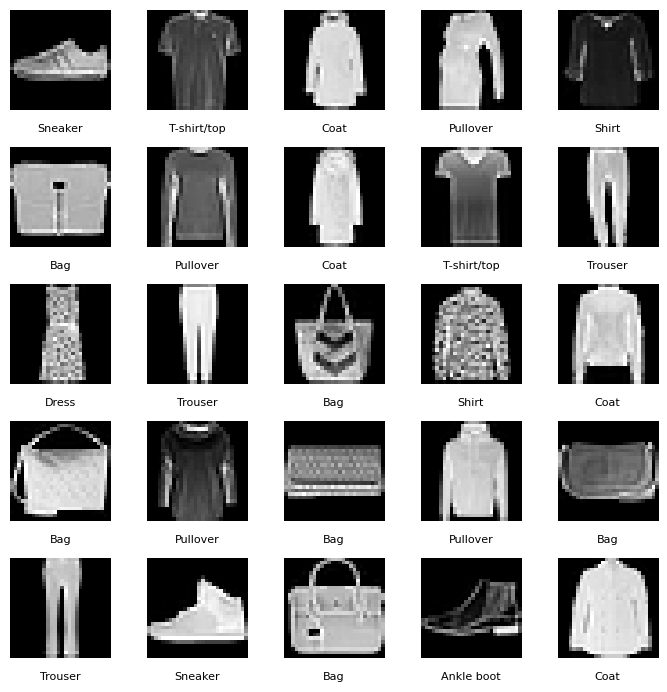

In [15]:
# Plot images with labels under them
plt.figure(figsize=(7, 7))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(class_names[labels[i]], fontsize=8, y=-0.3)
plt.tight_layout()
plt.show()


In [16]:
num_labels = len(np.unique(y_train))
print(num_labels)

10


In [17]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [18]:
# Normalize and reshape
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

## 🔹 2. Train MLP on MNIST

### ✅ Baseline Model

In [19]:
# Define baseline model
def build_baseline_model():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [20]:
baseline_model = build_baseline_model()
baseline_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
baseline_model.summary()

E0000 00:00:1749728183.732110     551 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1749728183.734679     551 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

### ✅ Train the model

In [21]:
history_baseline = baseline_model.fit(x_train, y_train, epochs=30,
                                      validation_split=0.2, batch_size=128, verbose=1)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7426 - loss: 0.7644 - val_accuracy: 0.8472 - val_loss: 0.4409
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8534 - loss: 0.4190 - val_accuracy: 0.8562 - val_loss: 0.4077
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8670 - loss: 0.3801 - val_accuracy: 0.8574 - val_loss: 0.3963
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8759 - loss: 0.3510 - val_accuracy: 0.8716 - val_loss: 0.3579
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8797 - loss: 0.3356 - val_accuracy: 0.8742 - val_loss: 0.3461
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8883 - loss: 0.3119 - val_accuracy: 0.8822 - val_loss: 0.3330
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8935 - loss: 0.2931 - val_accuracy: 0.8783 - val_loss: 0.3470
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8955 - loss: 0.2893 - val_accuracy: 0

In [22]:
def plot_learning_curves(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r--', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


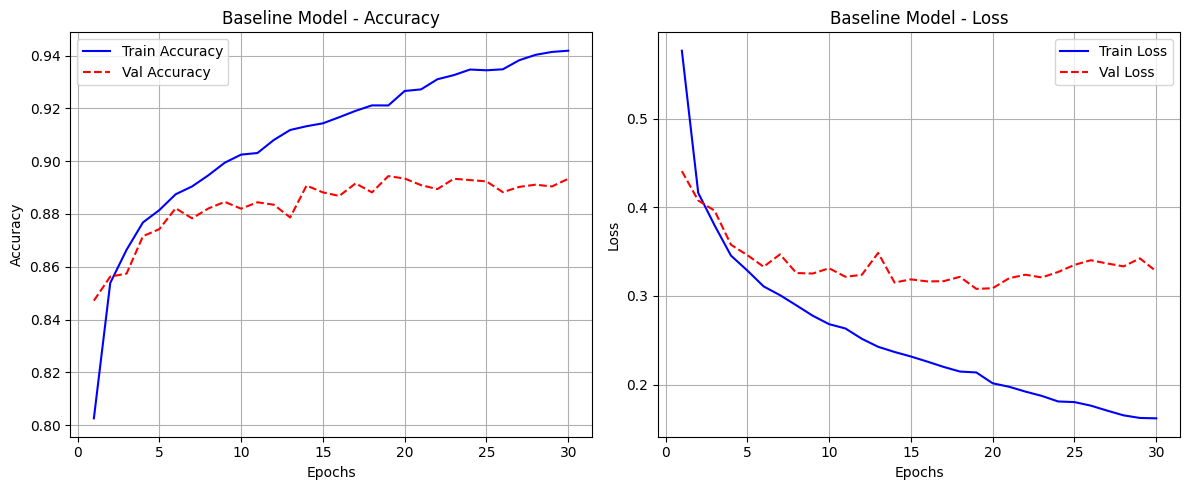

In [23]:
plot_learning_curves(history_baseline, title='Baseline Model')

### ✅ Evaluate model's performance

In [24]:
loss1, acc1 = baseline_model.evaluate(x_test, y_test)
print(f"Test accuracy : {100*acc1:.2f}%")
print(f"Test loss     : {100*loss1:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8860 - loss: 0.3562
Test accuracy : 88.45%
Test loss     : 35.67%


## 🔹 3. Underfitting vs Overfitting Models

In [25]:
# Underfitting: Very small model
def build_small_model():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Overfitting: Deep + Wide
def build_large_model():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [26]:
small_model = build_small_model()

small_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

small_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
large_model = build_large_model()

large_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

large_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_small = small_model.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=128)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6797 - loss: 0.9514 - val_accuracy: 0.8273 - val_loss: 0.4876
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8398 - loss: 0.4719 - val_accuracy: 0.8435 - val_loss: 0.4495
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8533 - loss: 0.4196 - val_accuracy: 0.8519 - val_loss: 0.4186
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8630 - loss: 0.3964 - val_accuracy: 0.8573 - val_loss: 0.4008
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8668 - loss: 0.3795 - val_accuracy: 0.8634 - val_loss: 0.3896
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8702 - loss: 0.3703 - val_accuracy: 0.8644 - val_loss: 0.3819
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8747 - loss: 0.3534 - val_accuracy: 0.8558 - val_loss: 0.3939
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8784 - loss: 0.3408 - val_accuracy: 0.

In [29]:
history_large = large_model.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=128)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7612 - loss: 0.6621 - val_accuracy: 0.8556 - val_loss: 0.3876
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8623 - loss: 0.3671 - val_accuracy: 0.8691 - val_loss: 0.3710
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8813 - loss: 0.3211 - val_accuracy: 0.8750 - val_loss: 0.3447
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8886 - loss: 0.2979 - val_accuracy: 0.8798 - val_loss: 0.3261
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8978 - loss: 0.2761 - val_accuracy: 0.8746 - val_loss: 0.3320
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9033 - loss: 0.2616 - val_accuracy: 0.8861 - val_loss: 0.3249
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9073 - loss: 0.2462 - val_accuracy: 0.8806 - val_loss: 0.3255
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9118 - loss: 0.2323 - val_accuracy: 

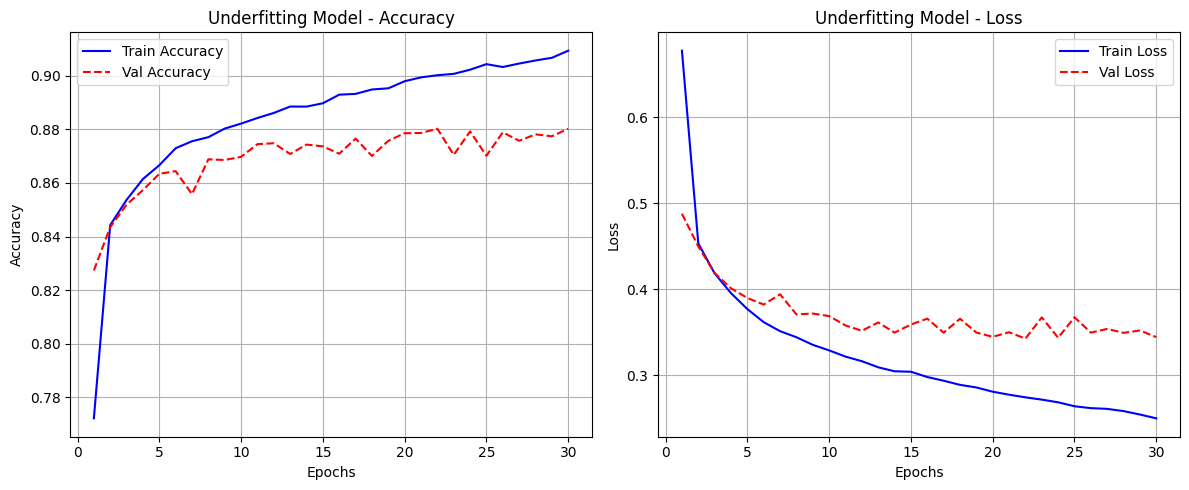

In [30]:
plot_learning_curves(history_small, title='Underfitting Model')

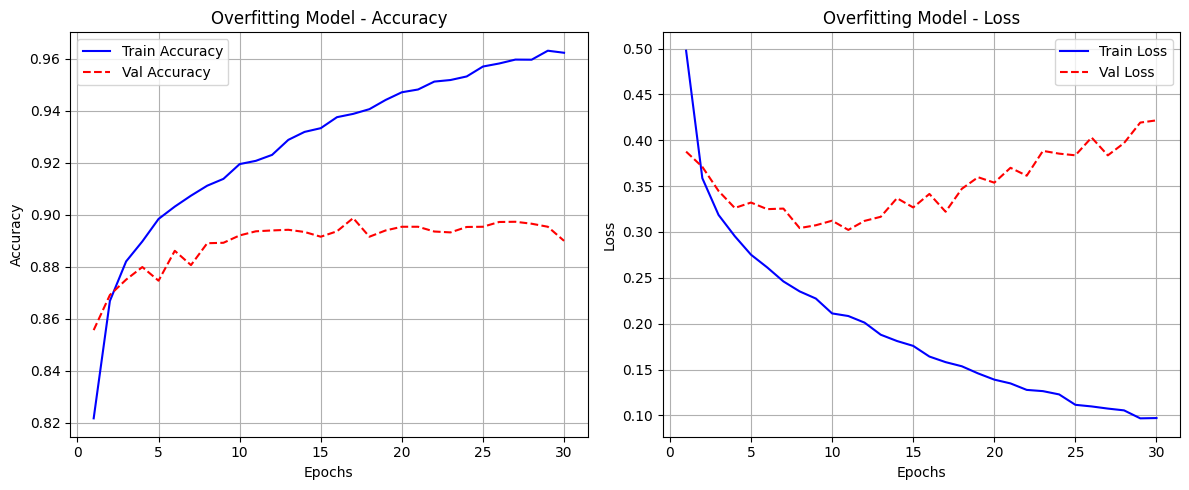

In [31]:
plot_learning_curves(history_large, title='Overfitting Model')

## 🔹 4. Regularized Model

### ✅ Dropout Regularization

In [32]:
def build_dropout_model():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    return model

reg_model_1 = build_dropout_model()
reg_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reg_model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history_reg_1 = reg_model_1.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=128)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7373 - loss: 0.7432 - val_accuracy: 0.8454 - val_loss: 0.4149
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8466 - loss: 0.4239 - val_accuracy: 0.8551 - val_loss: 0.4039
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8584 - loss: 0.3873 - val_accuracy: 0.8676 - val_loss: 0.3571
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8671 - loss: 0.3603 - val_accuracy: 0.8701 - val_loss: 0.3547
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8760 - loss: 0.3362 - val_accuracy: 0.8783 - val_loss: 0.3340
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8805 - loss: 0.3184 - val_accuracy: 0.8783 - val_loss: 0.3283
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8821 - loss: 0.3128 - val_accuracy: 0.8802 - val_loss: 0.3235
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8860 - loss: 0.3099 - val_accuracy: 0

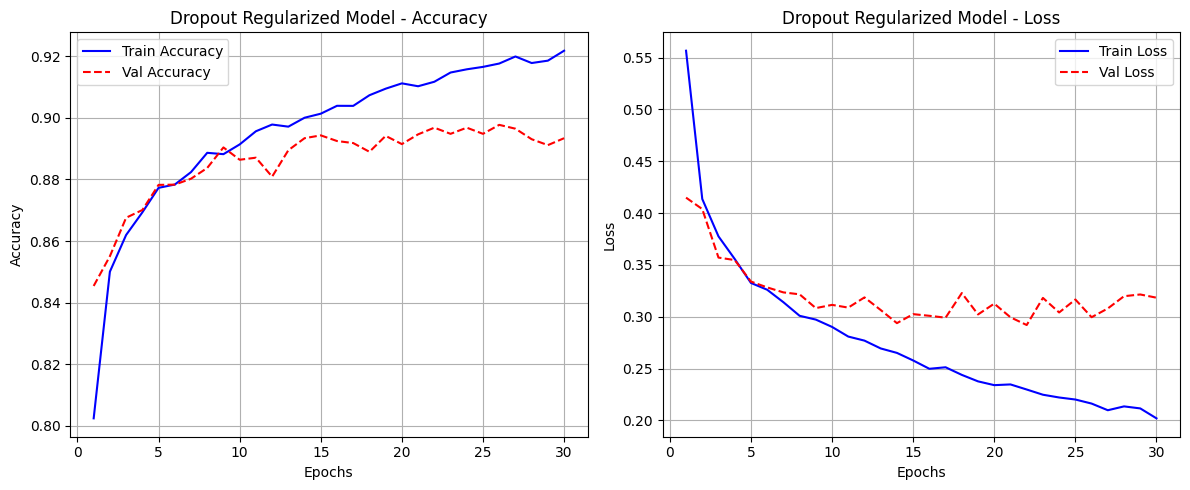

In [34]:
plot_learning_curves(history_reg_1, title='Dropout Regularized Model')

### ✅ L2 Regularization

In [35]:
def build_l2_regularized_model():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(10, activation='softmax')
    ])
    return model

reg_model_2 = build_l2_regularized_model()
reg_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reg_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history_reg_2 = reg_model_2.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=128)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7639 - loss: 1.3944 - val_accuracy: 0.8285 - val_loss: 0.7857
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8525 - loss: 0.6907 - val_accuracy: 0.8619 - val_loss: 0.5879
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8630 - loss: 0.5539 - val_accuracy: 0.8648 - val_loss: 0.5131
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8688 - loss: 0.4883 - val_accuracy: 0.8577 - val_loss: 0.5054
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8719 - loss: 0.4627 - val_accuracy: 0.8673 - val_loss: 0.4615
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8773 - loss: 0.4375 - val_accuracy: 0.8523 - val_loss: 0.4916
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8729 - loss: 0.4311 - val_accuracy: 0.8639 - val_loss: 0.4630
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8843 - loss: 0.4019 - val_accuracy

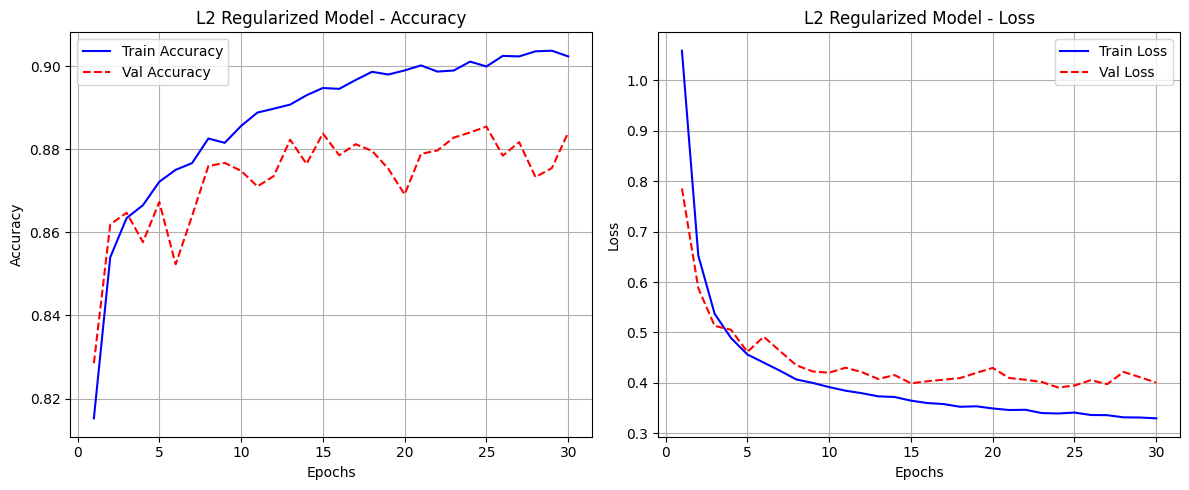

In [37]:
plot_learning_curves(history_reg_2, title='L2 Regularized Model')

### ✅ Combined Regularized Model

In [38]:
def build_regularized_model():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
    return model

reg_model_3 = build_regularized_model()
reg_model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reg_model_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history_reg_3 = reg_model_3.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=128)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7388 - loss: 1.4924 - val_accuracy: 0.8543 - val_loss: 0.7575
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8471 - loss: 0.7233 - val_accuracy: 0.8537 - val_loss: 0.6076
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8563 - loss: 0.5814 - val_accuracy: 0.8594 - val_loss: 0.5396
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8596 - loss: 0.5331 - val_accuracy: 0.8650 - val_loss: 0.5039
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8614 - loss: 0.5079 - val_accuracy: 0.8522 - val_loss: 0.5185
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8609 - loss: 0.4954 - val_accuracy: 0.8624 - val_loss: 0.4877
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8628 - loss: 0.4871 - val_accuracy: 0.8613 - val_loss: 0.4880
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8666 - loss: 0.4709 - val_accu

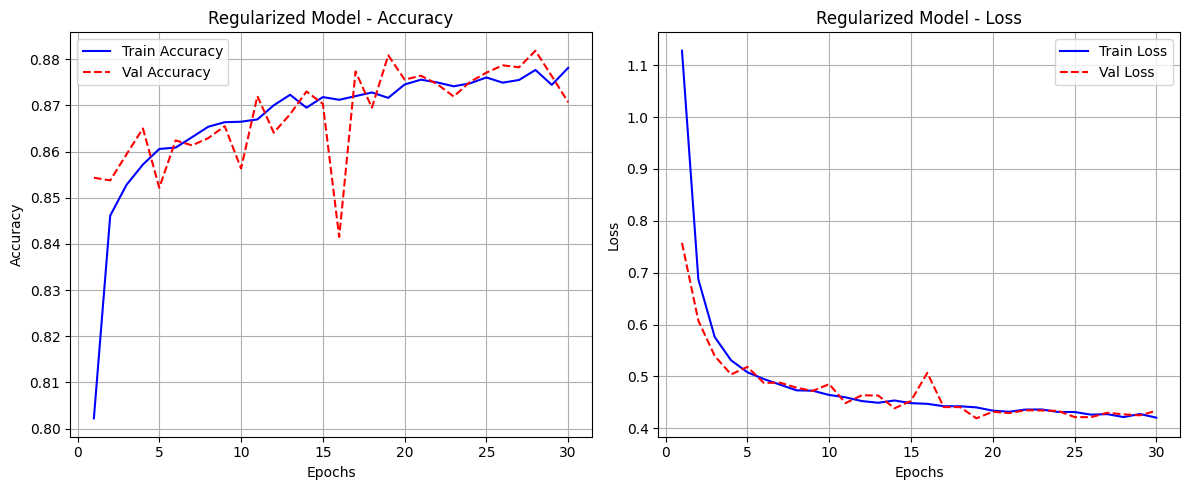

In [40]:
plot_learning_curves(history_reg_3, title='Regularized Model')

## 🔹 5. Comparison

In [41]:
# Evaluate on test set
models_dict = {
    "Baseline": baseline_model,
    "Underfitting": small_model,
    "Overfitting": large_model,
    "Dropout Regularized": reg_model_1,
    "L2 Regularized": reg_model_2,
    "Combined Regularized": reg_model_3
}

for name, model in models_dict.items():
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'{name} Model Test Accuracy: {test_acc:.4f}')

Baseline Model Test Accuracy: 0.8845
Underfitting Model Test Accuracy: 0.8754
Overfitting Model Test Accuracy: 0.8856
Dropout Regularized Model Test Accuracy: 0.8891
L2 Regularized Model Test Accuracy: 0.8751
Combined Regularized Model Test Accuracy: 0.8634


## 🔹 6. Learning Rate Experimentation

In [42]:
def build_lr_model():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Learning rates to test
learning_rates = {
    'Low LR (1e-5)': 1e-5,
    'Medium LR (1e-3)': 1e-3,
    'High LR (1e-1)': 1e-1
}

histories_lr = {}

for label, lr in learning_rates.items():
    print(f"\nTraining with {label}")
    model = build_lr_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=0)
    histories_lr[label] = history



Training with Low LR (1e-5)

Training with Medium LR (1e-3)

Training with High LR (1e-1)


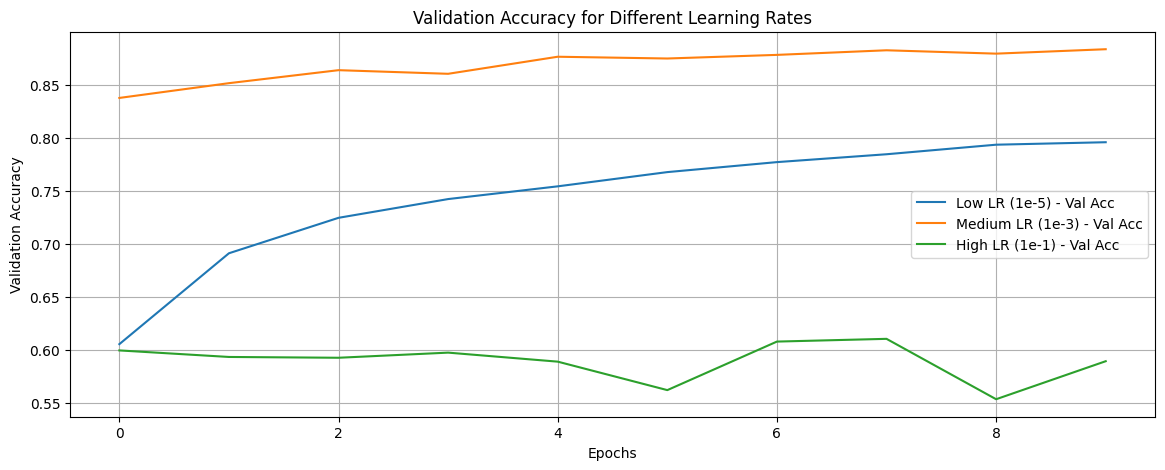

In [43]:
def plot_lr_comparisons(histories):
    plt.figure(figsize=(14, 5))

    for label, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{label} - Val Acc')

    plt.title("Validation Accuracy for Different Learning Rates")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_lr_comparisons(histories_lr)


## 🔹 4. Best Model

In [44]:
def build_best_mlp():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(10, activation='softmax')
    ])
    return model


In [45]:
best_mlp = build_best_mlp()
best_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
best_mlp.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,501,770 (5.73 MB)

 Trainable params: 1,501,770 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

### ✅ Define the Callbacks

In [46]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_fashion_mnist_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

### ✅ Train the Model with Callbacks

In [47]:
history_best_mlp = best_mlp.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[reduce_lr, checkpoint, early_stop],
    verbose=1
)

Epoch 1/100
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5138 - loss: 1.2568
Epoch 1: val_loss improved from inf to 0.52969, saving model to best_fashion_mnist_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5142 - loss: 1.2558 - val_accuracy: 0.7959 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 2/100
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7745 - loss: 0.6179
Epoch 2: val_loss improved from 0.52969 to 0.47656, saving model to best_fashion_mnist_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7745 - loss: 0.6179 - val_accuracy: 0.8183 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7984 - loss: 0.5521
Epoch 3: val_loss improved from 0.47656 to 0.44244, saving model to best_fashion_mnist_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7984 - loss: 0.5521 - val_accuracy: 0.8461 - val_loss: 0.4424 - learning_rate: 0.0010
Epoch 4/100
74

In [ ]:
plot_learning_curves(history_best_mlp, title='Best Model with Dropout + Callbacks')

In [ ]:
test_loss, test_acc = best_mlp.evaluate(x_test, y_test, verbose=0)
print(f'Best Model Test Accuracy: {test_acc:.4f}')